<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 3: Scaling Up(Food Vision mini)

In this notebook we scale up to all the classes in the Food101 dataset. The goal is to beat the original Food101 with 10% of the training data leveraging on the power of Transfer Learning

In [ ]:
!nvidia-smi

Sat Feb 10 15:45:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Getting our helper functions

In [ ]:

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-10 15:47:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-10 15:47:02 (81.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import required functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


### Download and unzip the data
Images have already been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

# set train and test directories
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

--2024-02-10 15:54:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   196MB/s    in 12s     

2024-02-10 15:54:59 (131 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# walk through the directory
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and

In [ ]:
# TODO: create a function to randomly plot images

In [ ]:
# set up data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
# BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    # batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
7575+25250

32825

## Train a big model with transfer learning on 10% of food 101 classes

A few steps to take:
* Create a ModelCheckpoint callback
* Create a data augumentation layer and build dta augumentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 base model
* Compile the model
* Feature extract on 5 full passes(5 epochs on the train dataset and validate on 15% of the test data)

### CheckPoint callback

In [ ]:
checckpoint_path = '101_classes_10%_data_model_chheckpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checckpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

### Data Augumentation Layer

In [ ]:
import keras
from keras import layers
from keras.models import Sequential

# setup data augumentation
data_augumentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1/255.) #for models that don't have rescaling in built
], name="data_augumentation_layer")

### Building the EfficientNet base model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augumentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation_layer (  (None, None, None, 3)     0         
 Sequential)                                                     
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

### Compile and fit the model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
TENSORBOARD_DIR = '101_food_classes_10_percent'
initial_epochs = 5
# fit
hist_all_classes_10_percent = model.fit(
    train_dataset,
    epochs=initial_epochs,
    steps_per_epoch=len(train_dataset),
    validation_data=test_dataset,
    validation_steps=int(.15 * len(test_dataset)),
    callbacks=[create_tensorboard_callback(
        dir_name=TENSORBOARD_DIR,
        experiment_name='model_1'
    ), checkpoint_callback]
)

Saving TensorBoard log files to: 101_food_classes_10_percent/model_1/20240210-163948
Epoch 1/5
237/237 [==============================] - 164s 643ms/step - loss: 3.3662 - accuracy: 0.2745 - val_loss: 2.4902 - val_accuracy: 0.4473
Epoch 2/5
237/237 [==============================] - 103s 431ms/step - loss: 2.2143 - accuracy: 0.4921 - val_loss: 2.0489 - val_accuracy: 0.5024
Epoch 3/5
237/237 [==============================] - 86s 361ms/step - loss: 1.8279 - accuracy: 0.5617 - val_loss: 1.8805 - val_accuracy: 0.5236
Epoch 4/5
237/237 [==============================] - 81s 339ms/step - loss: 1.5991 - accuracy: 0.6137 - val_loss: 1.7975 - val_accuracy: 0.5365
Epoch 5/5
237/237 [==============================] - 75s 312ms/step - loss: 1.4466 - accuracy: 0.6462 - val_loss: 1.7542 - val_accuracy: 0.5416


In [ ]:
# evelaute on the whole test dataset
test_1_results = model.evaluate(test_dataset)
test_1_results

790/790 [==============================] - 52s 65ms/step - loss: 1.5859 - accuracy: 0.5809


[1.5858677625656128, 0.5808712840080261]

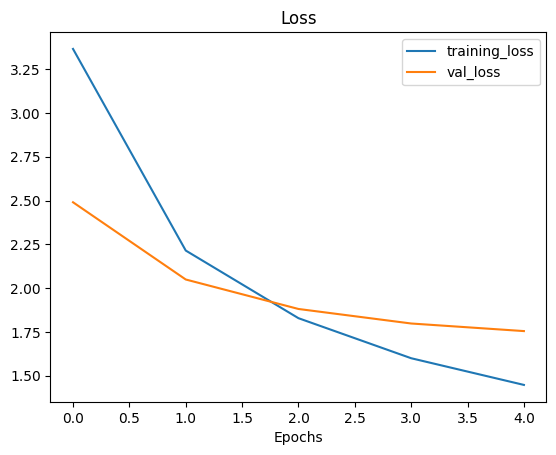

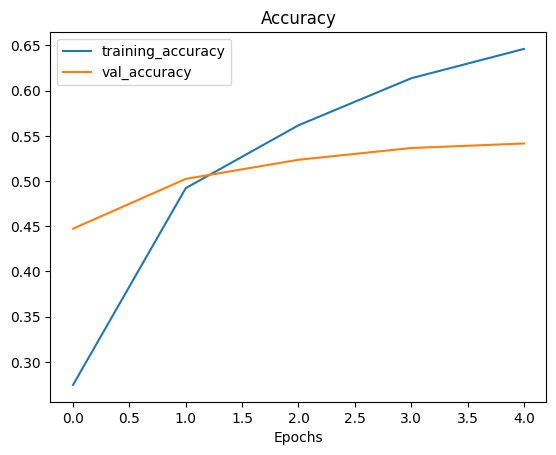

In [ ]:
# Plot loss curves
plot_loss_curves(hist_all_classes_10_percent)

## Fine Tuning the model

In [ ]:
# unfreeze the base model
base_model.trainable = True

# freeze back every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# check frozen and unfrozen layers
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# recompile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# fine-tune for 5 epochs
fine_tune_epochs = initial_epochs+ 5

hist_fine_tune_1 = model.fit(train_dataset,
                             epochs=fine_tune_epochs,
                             steps_per_epoch=len(train_dataset),
                             validation_data=test_dataset,
                             validation_steps=int(.15 * len(test_dataset)),
                             initial_epoch=hist_all_classes_10_percent.epoch[-1],
                             callbacks=[create_tensorboard_callback(
                                 dir_name=TENSORBOARD_DIR,
                                 experiment_name='model_2_fine_tune'
                             ), checkpoint_callback])

Saving TensorBoard log files to: 101_food_classes_10_percent/model_2_fine_tune/20240210-171858
Epoch 5/10
237/237 [==============================] - 77s 289ms/step - loss: 1.2170 - accuracy: 0.6846 - val_loss: 1.7403 - val_accuracy: 0.5418
Epoch 6/10
237/237 [==============================] - 68s 285ms/step - loss: 1.1119 - accuracy: 0.7051 - val_loss: 1.7026 - val_accuracy: 0.5490
Epoch 7/10
237/237 [==============================] - 58s 241ms/step - loss: 1.0148 - accuracy: 0.7302 - val_loss: 1.7376 - val_accuracy: 0.5471
Epoch 8/10
237/237 [==============================] - 61s 256ms/step - loss: 0.9463 - accuracy: 0.7485 - val_loss: 1.7506 - val_accuracy: 0.5379
Epoch 9/10
237/237 [==============================] - 58s 243ms/step - loss: 0.8991 - accuracy: 0.7575 - val_loss: 1.7330 - val_accuracy: 0.5434
Epoch 10/10
237/237 [==============================] - 57s 240ms/step - loss: 0.8413 - accuracy: 0.7745 - val_loss: 1.7226 - val_accuracy: 0.5471


In [ ]:
model_fine_tune1_results = model.evaluate(test_dataset)
model_fine_tune1_results

790/790 [==============================] - 62s 78ms/step - loss: 1.5119 - accuracy: 0.5991


[1.5118699073791504, 0.5990890860557556]

In [ ]:
test_1_results

[1.5858677625656128, 0.5808712840080261]

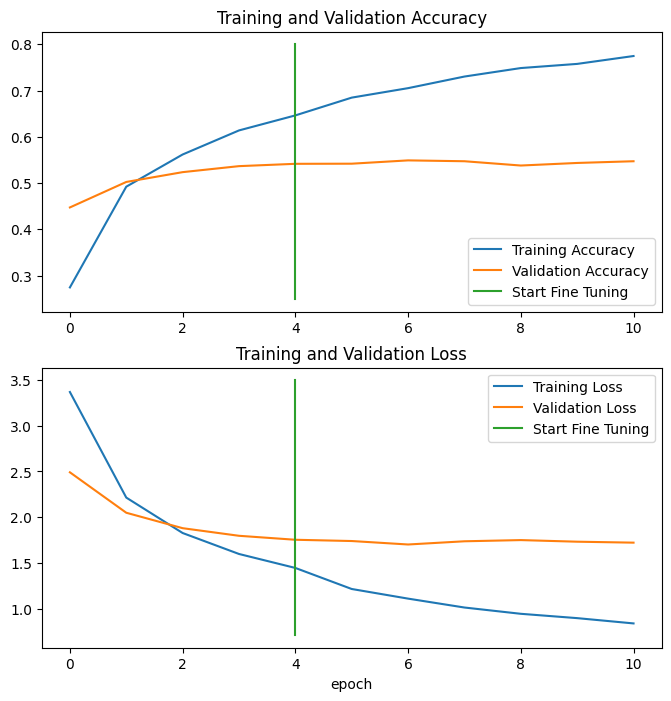

In [ ]:
compare_historys(original_history=hist_all_classes_10_percent,
                 new_history=hist_fine_tune_1,
                 initial_epochs=initial_epochs)

In [ ]:
# save our fine-tuning model
model.save('/content/drive/MyDrive/Colab_Notebooks/Models/101_food_classes_fine_tuned_model')

In [ ]:
# load tha model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/Models/101_food_classes_fine_tuned_model')

In [ ]:
loaded_model_results = loaded_model.evaluate(test_dataset)

790/790 [==============================] - 60s 74ms/step - loss: 1.5119 - accuracy: 0.5991


In [ ]:
loaded_model_results

[1.5118699073791504, 0.5990890860557556]

In [ ]:
model_fine_tune1_results

[1.5118699073791504, 0.5990890860557556]

In [ ]:
import tensorflow as tf

# load tha model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/Models/101_food_classes_fine_tuned_model')

## Evaluating the performance of the model
Let's make some predictions, visualize them and find out which ones are most wrong

In [1]:
# Download course pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-04-08 16:33:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   118MB/s    in 0.4s    

2024-04-08 16:33:32 (118 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2024-04-08 16:33:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-08 16:33:33 (84.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# unzip model
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [4]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [5]:
# Evaluate loaded model on test data
# first download test and train data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

# set train and test directories
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

--2024-04-08 16:33:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   220MB/s    in 6.4s    

2024-04-08 16:34:01 (241 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# Creating datasets

IMG_SIZE = (224, 224)
# BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    # batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
# Evaluate loaded model on test data
results_downloaded_model = model.evaluate(test_dataset)
results_downloaded_model

790/790 [==============================] - 65s 76ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making Predictions with our Trained Model

In [8]:
# Making predictions
pred_probs = model.predict(test_dataset, verbose=1)

790/790 [==============================] - 60s 74ms/step


In [9]:
len(pred_probs)

25250

In [10]:
# shape
pred_probs.shape

(25250, 101)

In [11]:
# The first 10 predictions
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [12]:
pred_probs[0], len(pred_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

In [13]:
index = tf.argmax(pred_probs[0])
pred_probs[0][index]

0.8474181

In [14]:
test_dataset.class_names[index]

'gyoza'

In [15]:
# Get one prediction probability per class
print(f"Number of perdiction probabilities for sample 0 : {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like : \n {pred_probs[0]}")
print(f"Class with the highest probability value for sample 0 : {pred_probs[0].argmax()}")

Number of perdiction probabilities for sample 0 : 101
What prediction probability sample 0 looks like : 
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.7315086

In [16]:
# Get pred classes for each label
pred_classes = pred_probs.argmax(axis=1)
# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now we have a predictions array of all our model's predictions, to evaluate them we need to compare them to  the true labels

In [17]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [18]:
# To get our test labels we need to unravel our test_dataset BatchDataset
y_labels = []
for images, labels in test_dataset.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions
We could do this by finding the accuracy score

In [19]:
# Try scikit-learn's accuracy metric
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [20]:
# compare accuracy to model's evaluation accuracy score
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Making a confusion matrix

In [21]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.xticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [22]:
class_names = test_dataset.class_names

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

## Classification report
Scikit learn has a function for acquiring classification reports per class called classification_report()

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [24]:
# Get a dictionary of clasification reports and visualize
classification_report_dict = classification_report(y_labels, pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [26]:
# create empty dictionary
class_f1_scores = {}
# loop through classification report dict
for key, value in classification_report_dict.items():
    if key == "accuracy":  #stop once we get to accuracy
        break
    else:
        # add class names and f1-scores to dictionary
        class_f1_scores[class_names[int(key)]] = value['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [27]:
# turn f1-scores into dataframe
import pandas as pd

f1_scores_df = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                             "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores_df

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


[Text(0, 0, 'edamame'),
 Text(0, 1, 'macarons'),
 Text(0, 2, 'pho'),
 Text(0, 3, 'spaghetti_carbonara'),
 Text(0, 4, 'oysters'),
 Text(0, 5, 'onion_rings'),
 Text(0, 6, 'mussels'),
 Text(0, 7, 'seaweed_salad'),
 Text(0, 8, 'miso_soup'),
 Text(0, 9, 'frozen_yogurt'),
 Text(0, 10, 'hot_and_sour_soup'),
 Text(0, 11, 'bibimbap'),
 Text(0, 12, 'spaghetti_bolognese'),
 Text(0, 13, 'dumplings'),
 Text(0, 14, 'pizza'),
 Text(0, 15, 'sashimi'),
 Text(0, 16, 'guacamole'),
 Text(0, 17, 'clam_chowder'),
 Text(0, 18, 'hot_dog'),
 Text(0, 19, 'french_fries'),
 Text(0, 20, 'poutine'),
 Text(0, 21, 'creme_brulee'),
 Text(0, 22, 'deviled_eggs'),
 Text(0, 23, 'donuts'),
 Text(0, 24, 'club_sandwich'),
 Text(0, 25, 'eggs_benedict'),
 Text(0, 26, 'beignets'),
 Text(0, 27, 'escargots'),
 Text(0, 28, 'churros'),
 Text(0, 29, 'chicken_wings'),
 Text(0, 30, 'pad_thai'),
 Text(0, 31, 'french_onion_soup'),
 Text(0, 32, 'fish_and_chips'),
 Text(0, 33, 'croque_madame'),
 Text(0, 34, 'cup_cakes'),
 Text(0, 35, 'lob

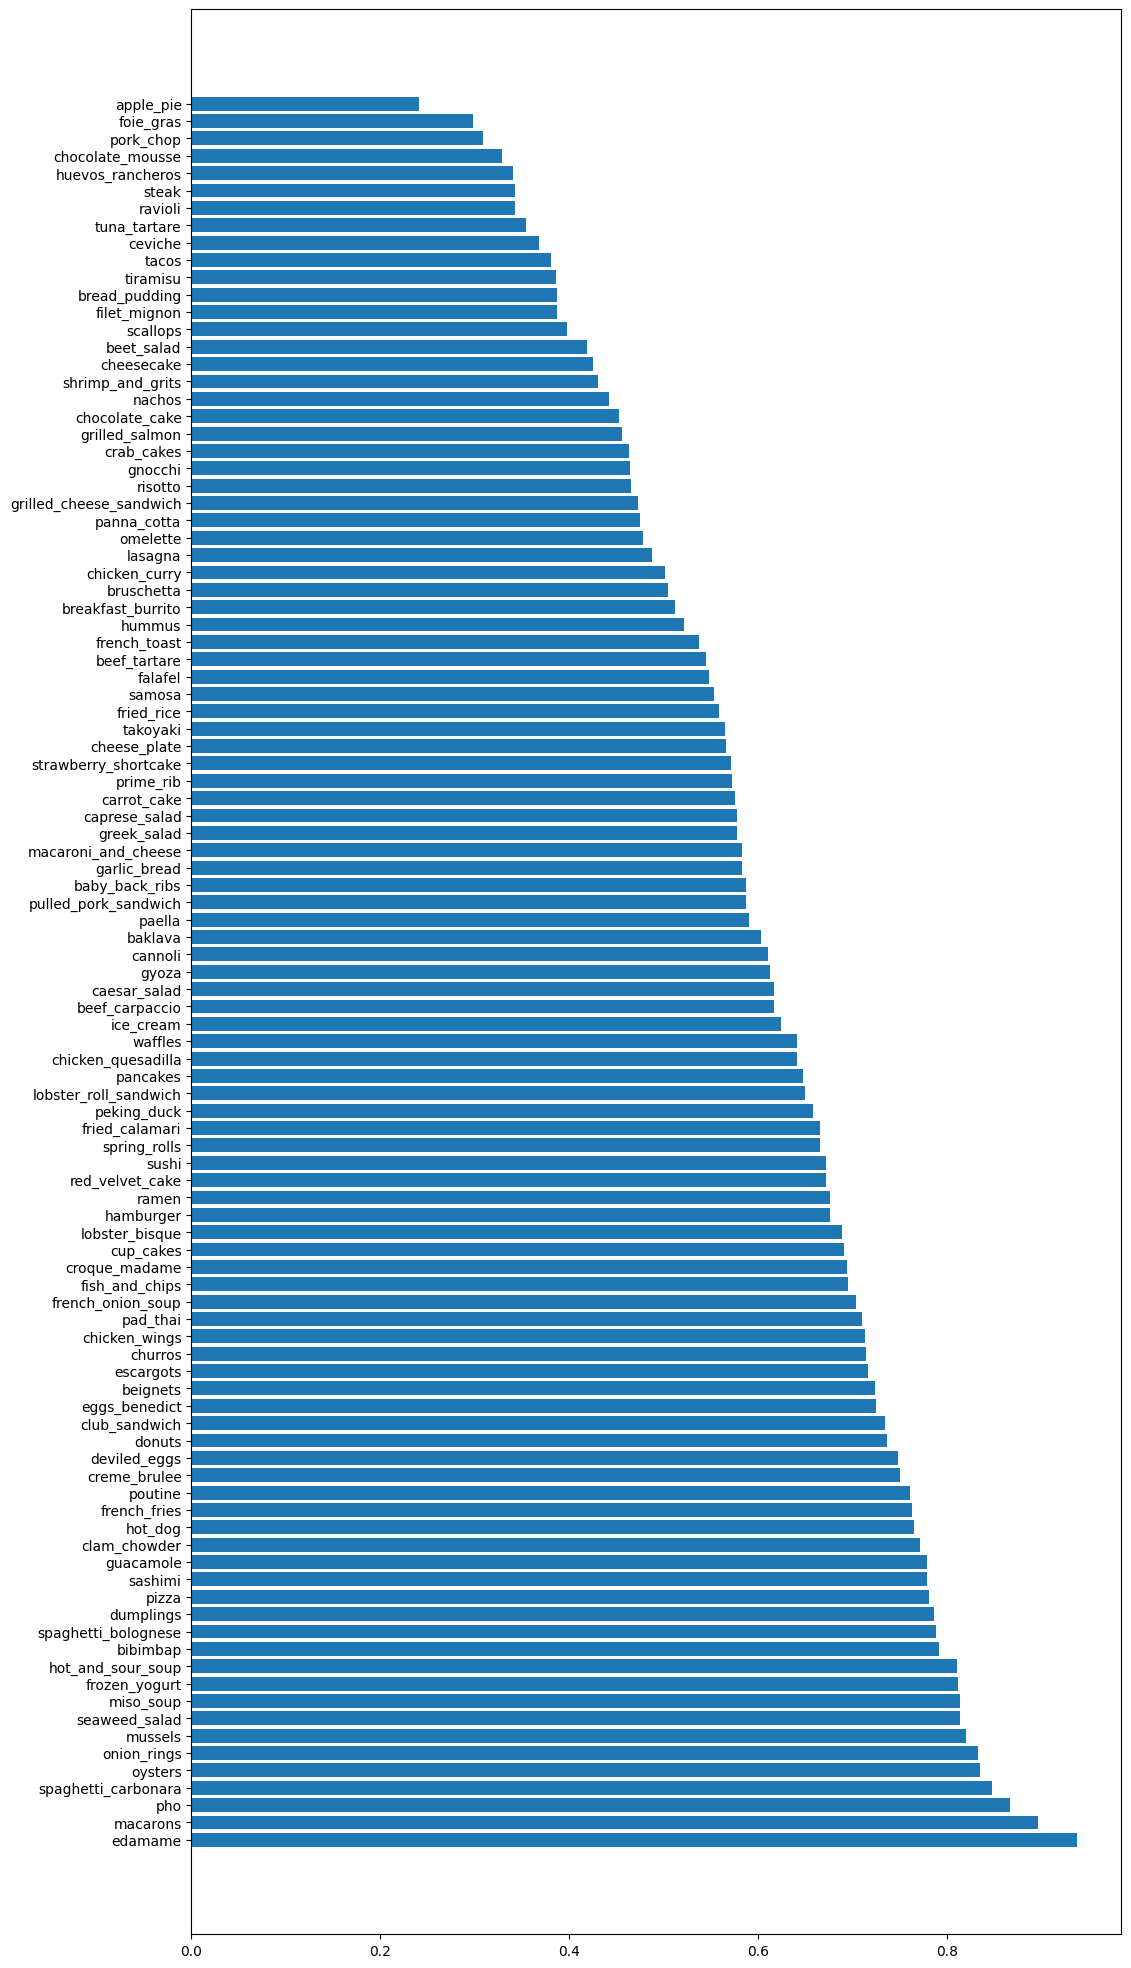

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_df)), f1_scores_df["f1-score"].values)
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(f1_scores_df["class_name"])